# Deep Learning
## Formative assessment
### Week 3: Loss functions and backpropagation

#### Instructions

In this notebook, you will write code to train an MLP model with both the high-level Keras API and a custom training loop, using the automatic differentiation tools from TensorFlow and a custom loss function.

Some code cells are provided you in the notebook. You should avoid editing provided code, and make sure to execute the cells in order to avoid unexpected errors. Some cells begin with the line: 

`#### GRADED CELL ####`

These cells require you to write your own code to complete them.

#### Let's get started!

We'll start by running some imports, and loading the dataset.

In [236]:
#### PACKAGE IMPORTS ####

# Run this cell first to import all required packages. Do not make any imports elsewhere in the notebook

import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from pathlib import Path
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization

# If you would like to make further imports from Tensorflow, add them here




<table><tr>
<td> <img src="figures/adelie.jpg" title="Adélie" style="width: 275px;"/> </td>
<td> <img src="figures/chinstrap.jpg" title="Chinstrap" style="width: 275px;"/> </td>
    <td> <img src="figures/gentoo.jpg" title="Gentoo" style="width: 275px;"/> </td>
</tr></table>

<center><font style="font-size:12px">source: <a href=https://en.wikipedia.org/wiki/Penguin>wikipedia</a></font></center>

#### The Palmer Penguins dataset
In this formative assessment, you will use the [Palmer Penguins dataset](https://allisonhorst.github.io/palmerpenguins/articles/intro.html). These data were collected from 2007 - 2009 by Dr. Kristen Gorman with the [Palmer Station Long Term Ecological Research Program](https://pal.lternet.edu/), part of the [US Long Term Ecological Research Network](https://lternet.edu/). The dataset consists of measurements for three penguin species observed in the Palmer Archipelago, Antarctica.

* Gorman, K.B., Williams, T.D. & Fraser, W.R. (2014), "Ecological sexual dimorphism and environmental variability within a community of Antarctic penguins (genus Pygoscelis)", PLoS ONE **9** (3):e90081, https://doi.org/10.1371/journal.pone.0090081

Your goal is to model the dataset using an MLP network, trained using the automatic differentiation tools in TensorFlow.

#### Load and preprocess the dataset

In [237]:
# Run this cell to load and sample the data

df = pd.read_csv(Path("./data/penguins.csv"))
df.sample(5)

,Body Mass (g),Clutch Completion,Comments,Culmen Depth (mm),Culmen Length (mm),Date Egg,Delta 13 C (o/oo),Delta 15 N (o/oo),Flipper Length (mm),Individual ID,Island,Region,Sample Number,Sex,Species,Stage,studyName
298,4250.0,No,Nest never observed with full clutch.,17.9,39.7,11/16/09,-25.88798,9.25769,193.0,N79A2,Dream,Anvers,140,MALE,Adelie,"Adult, 1 Egg Stage",PAL0910
292,5100.0,Yes,NaN,13.3,44.9,11/2/08,-26.89644,8.45167,213.0,N12A1,Biscoe,Anvers,49,FEMALE,Gentoo,"Adult, 1 Egg Stage",PAL0809
204,3575.0,Yes,NaN,17.1,45.9,11/22/07,-24.90024,9.12277,190.0,N70A1,Dream,Anvers,15,FEMALE,Chinstrap,"Adult, 1 Egg Stage",PAL0708
335,4800.0,Yes,NaN,20.7,52.0,11/14/08,-24.68440,9.43146,210.0,N69A2,Dream,Anvers,38,MALE,Chinstrap,"Adult, 1 Egg Stage",PAL0809
239,5800.0,Yes,NaN,16.0,48.6,11/6/08,-26.71199,8.59640,230.0,N56A2,Biscoe,Anvers,76,MALE,Gentoo,"Adult, 1 Egg Stage",PAL0809


We will work the following columns from the DataFrame:

In [238]:
# This is the list of columns to use as input features from the DataFrame

input_cols = ['Body Mass (g)', 'Culmen Depth (mm)', 'Culmen Length (mm)', 'Flipper Length (mm)']

In [239]:
# This is the column to use for the target variable

target_col = ['Species']

We will also use the `MinMaxScaler` from `sklearn` to scale the input features.

In [240]:
# Create a MinMax Scaler

scaler = MinMaxScaler()

You should now complete the following `get_inputs_and_targets` function, according to the following specifications:

* The function takes `dataframe`, `input_columns`, `target_column`, `minmaxscaler` as arguments
* Extract the inputs and target columns from the loaded DataFrame using `input_columns` and `target_column` lists
* Remove any rows with `NaN` values
* Scale the input features to the range $[0, 1]$ using the `minmaxscaler`
* The function should then return a tuple of constant `tf.Tensor` objects `(input_variables, target_variable)`
  * `input_variables` should be of type `tf.float32`, with shape `(num_examples, num_features)` 
  * `target_variable` should be of type `tf.string`, with shape `(num_examples,)`

In [241]:
#### GRADED CELL ####

# Complete the following function. 
# Make sure to not change the function name or arguments.

def get_inputs_and_targets(dataframe, input_columns, target_column, minmaxscaler):
    """
    This function takes in the loaded DataFrame and column lists as above, and a
    MinMaxScaler object. The function should extract the input and target features as 
    above, and return a tuple (input_variables, target_variable) of Tensors.
    """
    
    #drop nas together
    dataframe = dataframe[target_column + [ i for i in input_columns]].dropna()
    input_cols = dataframe[input_columns]
    target_col = dataframe[target_column]
    scaler = minmaxscaler
    scaler.fit(input_cols)
    input_cols = scaler.transform(input_cols)
    input_cols = tf.constant(input_cols, dtype = tf.float32)
    target_col = tf.constant(target_col, dtype = tf.string)
    target_col = tf.squeeze(target_col)
    
    return (input_cols, target_col)


In [242]:
# Run your function to get the input and target Tensors

X, y = get_inputs_and_targets(df, input_cols, target_col, scaler)


In [243]:
# Split the data into training and test sets

X_train, X_test, y_train, y_test = train_test_split(X.numpy(), y.numpy(), test_size=0.2)

In [244]:
# Load the data into tf.data.Dataset objects

train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))


The target variable needs to be further processed to convert the string labels to integer labels to train our model.

You should now complete the following `get_dataset` function according to the following specifications:

* The function takes `data` as an argument, which is a tuple of numpy arrays `(inputs, targets)`
* The training and test data should be loaded into a `tf.data.Dataset` object
* The `get_dataset` function should contain a nested function that is used in the `map` method of the Dataset to process the targets
  * The string targets should be converted to integer labels according to the following mapping:</br>
  `{"Adelie": 0, "Chinstrap": 1, "Gentoo": 2}`
* The resulting Dataset should return a tuple of `(inputs, targets)` Tensors, of types `tf.float32` and `tf.int32` respectively

In [245]:
#### GRADED CELL ####

# Complete the following function. 
# Make sure to not change the function name or arguments.

def get_dataset(data):
    """
    This function takes a tuple of numpy arrays, and creates a tf.data.Dataset
    object according to the above description.
    The function should then return the Dataset.
    """
    dataset = tf.data.Dataset.from_tensor_slices(data)
    def convert_label(inputs,target):
        if target == "Adelie":
            target = 0
        elif target == "Chinstrap":
            target = 1
        else:
            target = 2
        return inputs,target
    return dataset.map(convert_label)
    

In [246]:
# Create the training and test Datasets and print the element_spec

train_ds = get_dataset(data=(X_train, y_train))
test_ds = get_dataset(data=(X_test, y_test))

#print([(i,j) for (i, j) in train_ds])
train_ds.element_spec

(TensorSpec(shape=(4,), dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int32, name=None))

In [247]:
# Shuffle, batch and prefetch the Datasets

train_ds = train_ds.shuffle(X_train.shape[0]).batch(32).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.shuffle(X_test.shape[0]).batch(32).prefetch(tf.data.AUTOTUNE)


In [248]:
for a in train_ds:
    print(a)
print("-----------")
for a,i in train_ds:
    print(a)
#either:
    #each a is a batch of X,y
    #each a,i is the same but a is X, i is y

(<tf.Tensor: shape=(32, 4), dtype=float32, numpy=
array([[0.7083333 , 0.5       , 0.44727272, 0.7966102 ],
       [0.33333334, 0.8214286 , 0.22181818, 0.30508474],
       [0.125     , 0.45238096, 0.13090909, 0.22033899],
       [0.6944444 , 0.26190478, 0.53090906, 0.7966102 ],
       [0.30555555, 0.70238096, 0.63272727, 0.47457626],
       [0.3888889 , 0.6785714 , 0.6872727 , 0.5254237 ],
       [0.5       , 0.9047619 , 0.37818182, 0.42372882],
       [0.7916667 , 0.33333334, 0.6690909 , 0.84745765],
       [0.44444445, 0.07142857, 0.48      , 0.6440678 ],
       [0.3472222 , 0.70238096, 0.70181817, 0.4915254 ],
       [0.22222222, 0.5714286 , 0.52363634, 0.33898306],
       [0.5555556 , 0.13095239, 0.3890909 , 0.62711865],
       [0.5833333 , 0.9047619 , 0.7236364 , 0.6440678 ],
       [0.5555556 , 0.53571427, 0.3927273 , 0.40677965],
       [0.8055556 , 0.5       , 0.68      , 0.9491525 ],
       [0.30555555, 0.5119048 , 0.26909092, 0.23728813],
       [0.4861111 , 0.16666667, 0.4036

#### MLP model

You should now complete the following `get_model` function to build the MLP model we will use to train on the Palmer Penguins dataset.

* The function takes `hidden_units`, `output_units`, `input_shape`, `rate` as arguments
* You should build the model using the `Sequential` API
* `hidden_units` is a list of integers, specifying the width of the hidden layers within the model
  * Each hidden layer should use a sigmoid activation function
  * Each fully connected layer should be followed by a batch normalization layer, and then a dropout layer with dropout rate equal to `rate`
* The first layer in the model should set the input shape using the `input_shape` argument
* `output_units` is an integer specifying the number of neurons in the final output layer
  * The final output layer should not use an activation function

In [249]:
#### GRADED CELL ####

# Complete the following function. 
# Make sure to not change the function name or arguments.

def get_model(hidden_units, output_units, input_shape, rate):
    """
    This function should create an MLP model according to the above description.
    The function should then return the model.
    """
    penguin_model = Sequential()
    for i, neurons in enumerate(hidden_units):
        if i == 0:
            penguin_model.add(Dense(neurons, activation = "sigmoid", input_shape = input_shape))
            
        else:
            penguin_model.add(Dense(neurons, activation='sigmoid'))
        penguin_model.add(BatchNormalization())
        penguin_model.add(Dropout(rate=rate))
    #finally, deal with output layer :
    if len(hidden_units) == 0:
        penguin_model.add(Dense(output_units, input_shape=input_shape))
    else:
        penguin_model.add(Dense(output_units))
    return penguin_model

In [250]:
# Use your function to create a model and print the summary

model = get_model(hidden_units=[10, 10], output_units=3, input_shape=(4,), rate=0.8)
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_36 (Dense)            (None, 10)                50        
                                                                 
 batch_normalization_24 (Ba  (None, 10)                40        
 tchNormalization)                                               
                                                                 
 dropout_24 (Dropout)        (None, 10)                0         
                                                                 
 dense_37 (Dense)            (None, 10)                110       
                                                                 
 batch_normalization_25 (Ba  (None, 10)                40        
 tchNormalization)                                               
                                                                 
 dropout_25 (Dropout)        (None, 10)              

#### Loss function

We will train the model using a categorical cross entropy loss function. Since the final layer in the model does not use an activation function, it is returning the logits to be used in the computation of the loss function.

The categorical cross entropy for a single data example $(x, y)$ is given by:

$$
l(y, \hat{y}) = -\sum_{j=1}^C y_{j} \log \hat{y}_{j},\tag{1}
$$

where $C$ is the number of classes (in our case $C=3$), $y, \hat{y}\in\mathbb{R}^C$, and $\hat{y}_{j}$ is equal to the probability of the label $j$ as predicted by our neural network $f_\theta$ with parameters $\theta$, given the input $x$. In the above formulation the target label $y$ is represented as a one-hot vector. In our case, $y$ will be length three with two zeros and a single 1 in the place of the correct label.

Note also that the our model defined above outputs logits $z_j$, not probabilities. The probabilities are computed using the softmax function:

$$
\hat{y_j} = \frac{\exp(z_j)}{\sum_{k=1}^3 \exp(z_k)}.
$$

The loss function we want to minimise is the categorical cross entropy \eqref{cce} averaged over all examples in the training data. In practice, we will estimate this loss function by sampling minibatches of data and computing the average categorical cross entropy over the minibatch.

You should now complete the following `loss_function` function, to compute the categorical cross entropy loss as above.

In TensorFlow, loss functions have the signature `loss(y_true, y_pred)`, where `y_true` is the ground truth Tensor and `y_pred` is the model prediction given the inputs. The `compute_loss` function follows this signature, so we would be able to pass it to the `loss` argument directly when calling `model.compile`.

* The function takes `y_true` and `y_pred` as arguments
  * `y_true` is a batch of ground truth inputs, of shape `(num_examples,)` and type `tf.int32`
  * `y_pred` is a batch of model predictions, of shape `(num_examples, 3)` and type `tf.float32`
* The function should compute the categorical cross entropy as above
  * Bear in mind that `y_pred` will be a batch of logits, not probabilities
  * `y_true` contains the integer-encoded labels (either 0, 1 or 2)
* The function should average the categorical cross entropy over the minibatch, and return the result as a scalar Tensor

_Hint: you might find the functions [`tf.math.reduce_logsumexp`](https://www.tensorflow.org/api_docs/python/tf/math/reduce_logsumexp) and [`tf.gather`](https://www.tensorflow.org/api_docs/python/tf/gather) useful._

In [265]:
#### GRADED CELL ####

# Complete the following function. 
# Make sure to not change the function name or arguments.

 
    
def loss_function(y_true, y_pred):
    """
    This function should compute the categorical cross entropy loss as described above.
    The function should return a scalar Tensor with the computed loss value.
    """
    ### LOOK at yjhat
    # logyjhat = zj - logsumexp(zrow) = ypred - logsumexp(yjrow)
    Z = tf.math.reduce_logsumexp(y_pred, axis=-1, keepdims=True)  # (num_examples, 1)
    logprob = y_pred - Z  # (num_examples, 3)
    #way of indexing, we specify the vector and indices
    #so we tell it  the dimension that is the batch (like data n)
    #and we tell it which way across the batch to find the mean
    #we actually dont need axis since other than batch dims there is only one other dimension
    return -tf.reduce_mean(tf.gather(logprob, y_true, batch_dims=1,axis = 1))

In [266]:
# Get a ground truth and predictions Tensor to test your function

inputs, y_true = next(iter(train_ds))
#print(y_true)
y_pred = model(inputs)
#print(y_pred.shape[0])

#tf.keras.activations.softmax(y_pred,axis = 1)

In [267]:
# Compute the loss on the batch of data using your function

loss_function(y_true, y_pred)

<tf.Tensor: shape=(), dtype=float32, numpy=1.0979652>

In [268]:
# Check to see that your computed loss agrees with the built-in TensorFlow function

tf.reduce_mean(tf.keras.metrics.sparse_categorical_crossentropy(y_true, y_pred, from_logits=True))

<tf.Tensor: shape=(), dtype=float32, numpy=1.0979652>

#### Train your model with the high-level Keras API

You should now complete the following `train_model_keras` function to train the MLP model using the high-level Keras API.

* The function takes `mlp_model`, `loss_fn`, `opt`, `training_dataset` and `epochs` as arguments
* The function should use the high-level Keras API to compile and train the model
  * Use the `compile` method to compile `mlp_model` using the loss function `loss_fn`, `opt` optimizer and accuracy metric
  * Train with the `fit` method, using `training_dataset` for `epochs` epochs
* The function should then return the training history

In [269]:
#### GRADED CELL ####

# Complete the following function. 
# Make sure to not change the function name or arguments.

def train_model_keras(mlp_model, loss_fn, opt, training_dataset, epochs):
    """
    This function should use the compile and fit methods to train the MLP model.
    The function should return the history from the training.
    """
    mlp_model.compile(loss = loss_fn, optimizer = opt, metrics=['accuracy'])
    return mlp_model.fit(training_dataset, epochs = epochs,verbose = 0)
    

In [270]:
# Create an SGD optimizer

optimizer = tf.keras.optimizers.SGD()

In [271]:
# Compile and fit the MLP model

model = get_model(hidden_units=[40, 20], output_units=3, input_shape=(4,), rate=0.5)
history = train_model_keras(model, loss_fn=loss_function, opt=optimizer, 
                            training_dataset=train_ds, epochs=200)

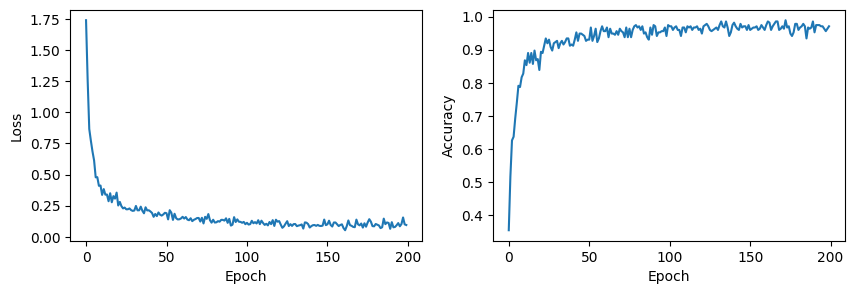

In [272]:
# Plot the learning curves

plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

In [273]:
# Evaluate the model

model.evaluate(test_ds)

3/3 [==============================] - 0s 3ms/step - loss: 0.0209 - accuracy: 1.0000


[0.02086447738111019, 1.0]

#### Train your model with a custom training loop

You will now implement a custom training loop to train an MLP model on the Palmer Penguins dataset, making use of the automatic differentiation tools in TensorFlow.

First you should complete the following `train_step` function, which will implement the core operations of computing the loss and gradients, and updating the model parameters.

* The function takes the arguments `mlp_model`, `loss_fn`, `opt` and `train_batch`
* `train_batch` is a tuple of `(inputs, targets)` Tensors yielded from the Dataset
* The function should compute the batch loss using `train_batch`, `mlp_model` and `loss_fn`
  * The model should be run in training mode (see [the docs](https://www.tensorflow.org/api_docs/python/tf/keras/Model#call))
* It should then compute the gradients and update the model parameters using the optimizer `opt`
* It should return a tuple of three Tensors: `(loss, y_true, y_pred)`
  * `loss` is the scalar batch loss as computed by `loss_fn`
  * `y_true` is the ground truth Tensor for the batch
  * `y_pred` is the model predictions Tensor for the batch

In [278]:
#### GRADED CELL ####

# Complete the following function. 
# Make sure to not change the function name or arguments.


@tf.function
def train_step(mlp_model, loss_fn, opt, train_batch):
    """
    This function should perform the update step as described above.
    The function should return a tuple of Tensors (loss, y_true, y_pred).
    """
    inputs,y_true = train_batch
    #we want the gradient of the loss function
    with tf.GradientTape() as tape:
        # WE HAVE TO HAVE TRAINING = TRUE TO TELL IT THAT WE ARE IN THE TRAINING PHASE
        y_pred = mlp_model(inputs,training = True)
        loss = loss_fn(y_true,y_pred)
    grads = tape.gradient(loss, mlp_model.trainable_weights)
    
    opt.apply_gradients(zip(grads, mlp_model.trainable_weights))
    return loss, y_true, y_pred


You should now complete the following `train_model_custom` function to perform the custom training loop. We will use two metric objects (defined below) to record the loss and accuracy values over the course of training. See the docs for the base [`Metric`](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/Metric) class to see the generic methods that are available.

* The function takes `mlp_model`, `loss_fn`, `opt`, `training_dataset`, `train_step_fn`, `epochs`, `loss_metric` and `accuracy_metric` as arguments
* The custom training loop should consist of an outer loop for the epochs, that runs for `epochs` number of times
* At the start of each epoch, the metric states should be reset using the `reset_state` method
* Within each epoch, the function should loop over `training_dataset` to pull batches of data
* For each batch, it should use `train_step_fn` to update the model parameters
  * This function returns a tuple of Tensors `(loss, y_true, y_pred)`
  * For each batch, the metrics should also be updated, using the `update_state` method
* The average loss and accuracy over each epoch should each be stored in a list of floats
  * The average loss and accuracy can be retrieved from the metrics at the end of the epoch using the `result` method
* The function should return a tuple of the two lists `(epoch_losses, epoch_acc)` for average loss and accuracy scores per epoch

In [279]:
# Define the loss and accuracy metrics and optimizer

loss_metric = tf.keras.metrics.Mean()
accuracy_metric = tf.keras.metrics.SparseCategoricalAccuracy()
optimizer = tf.keras.optimizers.SGD()

In [280]:
#### GRADED CELL ####

# Complete the following function. 
# Make sure to not change the function name or arguments.

def train_model_custom(mlp_model, loss_fn, opt, training_dataset, train_step_fn, epochs, 
                       loss_metric=loss_metric, accuracy_metric=accuracy_metric):
    """
    This function should run the custom training loop as described above.
    The function should return a tuple of two lists with the loss and accuracy scores.
    """
    epoch_losses = []
    epoch_acc = []
    
    for epoch in range(epochs):
        loss_metric.reset_state()
        accuracy_metric.reset_state()
        
        for train_batch in training_dataset:
            #we want ytrue and ypred so we can do accuracy
            loss, y_true, y_pred = train_step_fn(mlp_model, loss_fn, opt, train_batch)
            loss_metric.update_state(loss)
            accuracy_metric.update_state(y_true, y_pred)
            
        avg_epoch_loss = float(loss_metric.result().numpy())
        avg_epoch_acc = float(accuracy_metric.result().numpy())
        epoch_losses.append(avg_epoch_loss)
        epoch_acc.append(avg_epoch_acc)
        if epoch % 10 == 0:
            print(f"Epoch {epoch}: loss - {avg_epoch_loss:.4f}, accuracy = {avg_epoch_acc:.4f}")
    
    return epoch_losses, epoch_acc
    

In [281]:
# Use your function to run the custom training loop

model = get_model(hidden_units=[40, 20], output_units=3, input_shape=(4,), rate=0.5)
epoch_losses, epoch_acc = train_model_custom(model, loss_fn=loss_function, opt=optimizer,
                                             training_dataset=train_ds, 
                                             train_step_fn=train_step, epochs=200)

Epoch 0: loss - 0.9901, accuracy = 0.5861
Epoch 10: loss - 0.3736, accuracy = 0.8498
Epoch 20: loss - 0.2645, accuracy = 0.9084
Epoch 30: loss - 0.2121, accuracy = 0.9487
Epoch 40: loss - 0.2093, accuracy = 0.9121
Epoch 50: loss - 0.1568, accuracy = 0.9414
Epoch 60: loss - 0.1344, accuracy = 0.9597
Epoch 70: loss - 0.1302, accuracy = 0.9560
Epoch 80: loss - 0.1447, accuracy = 0.9524
Epoch 90: loss - 0.1733, accuracy = 0.9414
Epoch 100: loss - 0.1422, accuracy = 0.9524
Epoch 110: loss - 0.1439, accuracy = 0.9670
Epoch 120: loss - 0.1723, accuracy = 0.9451
Epoch 130: loss - 0.1174, accuracy = 0.9670
Epoch 140: loss - 0.1139, accuracy = 0.9634
Epoch 150: loss - 0.0805, accuracy = 0.9670
Epoch 160: loss - 0.1198, accuracy = 0.9670
Epoch 170: loss - 0.1409, accuracy = 0.9560
Epoch 180: loss - 0.0905, accuracy = 0.9707
Epoch 190: loss - 0.1055, accuracy = 0.9670


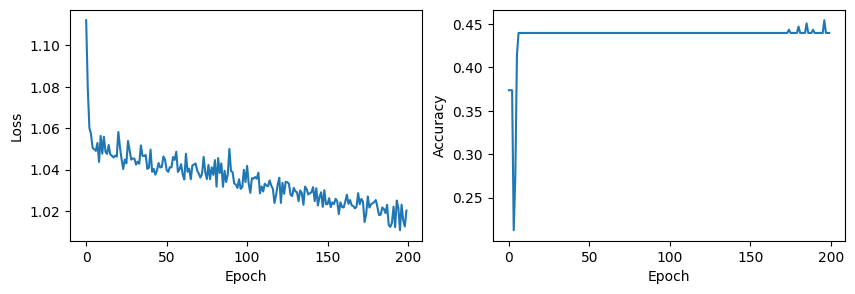

In [264]:
# Plot the learning curves

plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
plt.plot(epoch_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(1, 2, 2)
plt.plot(epoch_acc)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

#### Evaluate your model

Finally, you will also implement custom code to evaluate your model. First you should complete the following `test_step` function, which is similar to the `train_step` function, except that it does not compute gradients or update the model parameters.

* The function takes the arguments `mlp_model`, `loss_fn` and `test_batch`
* `test_batch` is a tuple of `(inputs, targets)` Tensors yielded from the Dataset
* The function should compute the batch loss using `test_batch`, `mlp_model` and `loss_fn`
  * The model should be run in inference mode (see [the docs](https://www.tensorflow.org/api_docs/python/tf/keras/Model#call))
* The function should return a tuple of three Tensors: `(loss, y_true, y_pred)`
  * `loss` is the scalar batch loss as computed by `loss_fn`
  * `y_true` is the ground truth Tensor for the batch
  * `y_pred` is the model predictions Tensor for the batch

In [283]:
#### GRADED CELL ####

# Complete the following function. 
# Make sure to not change the function name or arguments.

@tf.function
def test_step(mlp_model, loss_fn, test_batch):
    """
    This function should perform the evaluation step as described above.
    The function should return a tuple of Tensors (loss, y_true, y_pred).
    """
    inputs, targets = test_batch
    #we specify training = false to show we arent training it
    y_pred = mlp_model(inputs, training=False)
    loss = loss_fn(targets,y_pred)
    return loss, targets, y_pred
    

Now you should complete the following `test_model_custom` function that will evaluate the model on a test dataset. This will be similar to the `train_model_custom` function, except that no optimizer is used/needed and no parameter updates are made.

* The function takes `mlp_model`, `loss_fn`, `test_dataset`, `test_step_fn`, `loss_metric` and `accuracy_metric` as arguments
* The evaluation should make one complete iteration loop through `test_dataset`
* At the start of the loop, the metric states should be reset using the `reset_state` method
* For each batch, you should use `test_step_fn` to compute the loss and model prediction
  * This function returns a tuple of Tensors `(loss, y_true, y_pred)`
  * For each batch, the metrics should also be updated, using the `update_state` method
* The average loss and accuracy should be retrieved from the metrics at the end of the loop using the `result` method
* The function should return a tuple of two floats `(avg_loss, avg_acc)` for average loss and accuracy scores over the `test_dataset`

In [284]:
#### GRADED CELL ####

# Complete the following function. 
# Make sure to not change the function name or arguments.

def test_model_custom(mlp_model, loss_fn, test_dataset, test_step_fn, 
                      loss_metric=loss_metric, accuracy_metric=accuracy_metric):
    """
    This function should run the custom evaluation loop as described above.
    The function should return a tuple of two floats for the loss and accuracy scores.
    """
    loss_metric.reset_state()
    accuracy_metric.reset_state()

    for test_batch in test_dataset:
        loss, y_true, y_pred = test_step_fn(mlp_model, loss_fn, test_batch)
        #update loss and accuracy
        loss_metric.update_state(loss)
        accuracy_metric.update_state(y_true, y_pred)

    #.result returns the metric we want, so mean for loss, and accuracy (which is sort of a mean) for accuracy
    avg_loss = float(loss_metric.result().numpy())
    avg_acc = float(accuracy_metric.result().numpy())
        
    return avg_loss, avg_acc
    

In [285]:
# Use your function to evaluate the model

avg_loss, avg_acc = test_model_custom(model, loss_function, test_ds, test_step)
print(f"Test loss: {avg_loss}")
print(f"Test accuracy: {avg_acc}")

Test loss: 0.01989133097231388
Test accuracy: 1.0


Congratulations on completing this week's assignment! You have now written custom code to implement a loss function, training loop and evaluation loop for an MLP model.